# KERAS and TENSORFLOW
We start by importing all the necessary packages
(%lsmagic for magic commanda and ! for bash instruction)

In [9]:
import sys;
import os, sys, array, re, math, random, subprocess, glob
from math import *
import numpy as np
import scipy
from numpy.lib.recfunctions import stack_arrays
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cPickle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Highway, MaxoutDense, Masking, GRU, Merge, Input, merge
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
import deepdish.io as io
import ROOT
from ROOT import gSystem, gROOT, gApplication, TFile, TTree, TCut, TH1F, TCanvas
from root_numpy import root2array, root2array 
print "I you had no error so far, this is great! We can start the tutorial."

I you had no error so far, this is great! We can start the tutorial.


We set some variables we will use later

In [10]:
# Check this file out, it contains many functions we will use.
execfile("Useful_func.py")
# Fix random seed for reproducibility
seed = 7; np.random.seed(seed);
# Input paramters
debug = True #(Verbose output)
folder='Plots_Hhh_tt_MLP/' # Folder with Plots
MakePlots=True # Set False if you want to run faster
folderCreation  = subprocess.Popen(['mkdir -p ' + folder], stdout=subprocess.PIPE, shell=True); folderCreation.communicate()
folderCreation2 = subprocess.Popen(['mkdir -p models/'], stdout=subprocess.PIPE, shell=True); folderCreation2.communicate()

# Pre-selection and branches to include

('', None)

Now We Start manipulating ROOT files into a format we can use to train a MVA

In [11]:
# Our goal is to separate BX Signal from TT background. The machine learning only want to analyze "good events"
# We defoe god events by: 
# 1) Applying a preselection to out Signal and background events
my_selec = 'MMC_h2massweight1_prob>200 && hasRECOjet1 && hasRECOjet1 && hasMET && hastwomuons && (((b1jet_btag&2)>0 && (b2jet_btag&3)>0) || ((b1jet_btag&3)>0 && (b 2jet_btag&2)>0)) && dR_l1l2<3.3 && dR_l1l2>0.07 && dR_b1b2<5. && mass_l1l2<100 && mass_l1l2>5. && mass_b1b2>150 && dR_bl<5 && dR_l1l2b1b2<6 && MINdR_bl<3.2 && MINdR_bl>0.4 && mass_b1b2<700 && mass_trans<250 && MT2<400 && pt_b1b2<300'
# 2) Selecting the branches that contains the information we want to use (in general)
my_branches =  ["dR_l1l2","dR_b1b2","dR_bl","dR_l1l2b1b2","MINdR_bl","dphi_l1l2b1b2","mass_l1l2","mass_b1b2","mass_trans","MT2","pt_b1b2","weight","reweighting","MMC_h2massweight1_prob"]
# 3) Selecting the branches that contains the information we want to use (in the training)
my_branches_training = ["dR_l1l2","dR_b1b2","dR_bl","dR_l1l2b1b2","MINdR_bl","dphi_l1l2b1b2","mass_l1l2","mass_b1b2","mass_trans","MT2","pt_b1b2","MMC_h2massweight1_prob"]

# Converting Root files in dataframe (Very useful, checnl root2panda in Useful_func.py)
Hhh3  = root2panda('files_root/delphes_B3_1M_PU40ALL_1Ag_mvammc_TRIMMED.root', 'evtree', branches=my_branches, selection=my_selec)
ttbar = root2panda('files_root/delphes_tt_4M_PU40_WtomuALL_1Ag_mvammc_TRIMMED_5Kevents.root', 'evtree', branches=my_branches, selection=my_selec)
# Create a variable that is the total weight (weight=weight for xsec, reweighting=weight depending on muons)
Hhh3['fin_weight']  = Hhh3['weight']*Hhh3['reweighting']
ttbar['fin_weight'] = ttbar['weight']*ttbar['reweighting']
## Save the dataframe as h5 file (for quick loading in the future).
#io.save(open('models/ttbar.h5', 'wb'), ttbar)
#ttbar = io.load(open('models/ttbar.h5', 'rb'))

if debug:
  print("---> Hhh3 Displayed as panda dataframe: "); print(Hhh3)
  print("The shape for Hhh3 is [nb_events, nb_variables]: "); print(Hhh3.shape)
  print("The shape for tt is [nb_events, nb_variables]: "); print(ttbar.shape)

---> Hhh3 Displayed as panda dataframe: 
      dR_l1l2   dR_b1b2     dR_bl  dR_l1l2b1b2  MINdR_bl  dphi_l1l2b1b2  \
0    0.835309  2.426065  1.771351     2.456219  1.771351       2.439342   
1    1.680773  3.461864  2.625820     3.189628  1.296153       3.104695   
2    2.613559  3.463338  1.169699     1.112213  1.169699       0.488734   
3    0.555706  2.797136  2.208439     3.274508  1.852719       1.813255   
4    1.265501  3.291811  2.542928     2.743070  2.019794       1.932036   
5    0.789705  2.080813  2.188340     2.450307  1.663508       2.449623   
6    0.134017  3.206850  3.176847     3.489993  1.842429       2.511945   
7    0.999802  2.457096  2.990820     3.072848  2.166252       1.740511   
8    1.278717  3.796422  3.203525     3.048047  0.625945       1.071269   
9    0.753285  3.444453  3.334925     3.395689  1.011419       2.675913   
10   2.449032  2.889399  1.960407     3.281974  0.530522       3.125057   
11   0.874256  2.122234  1.336319     1.749813  1.312641   

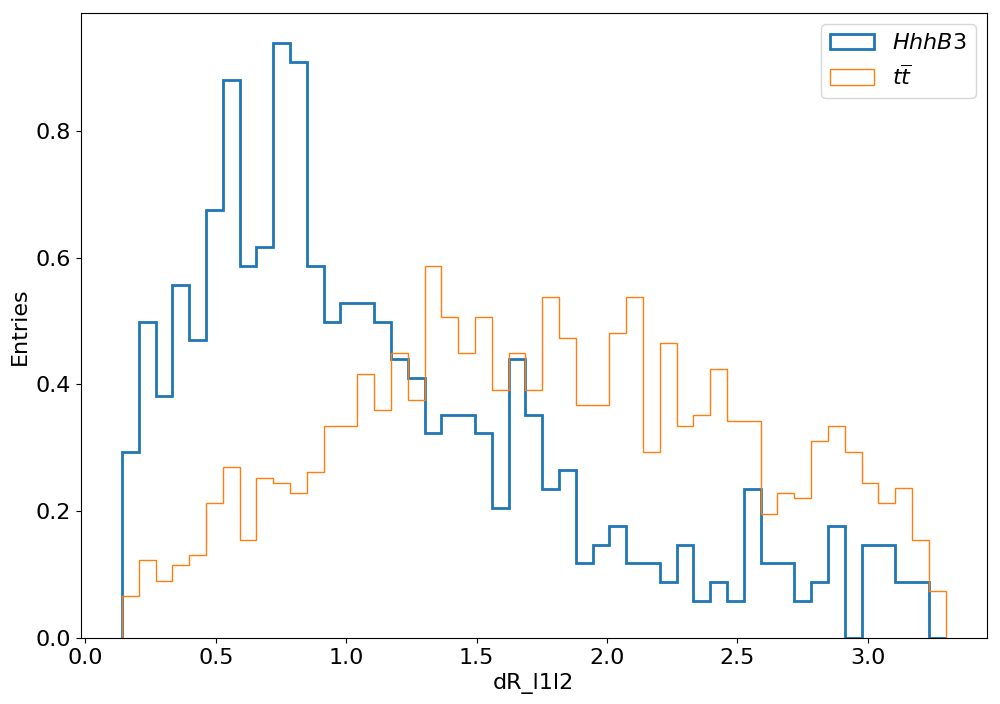

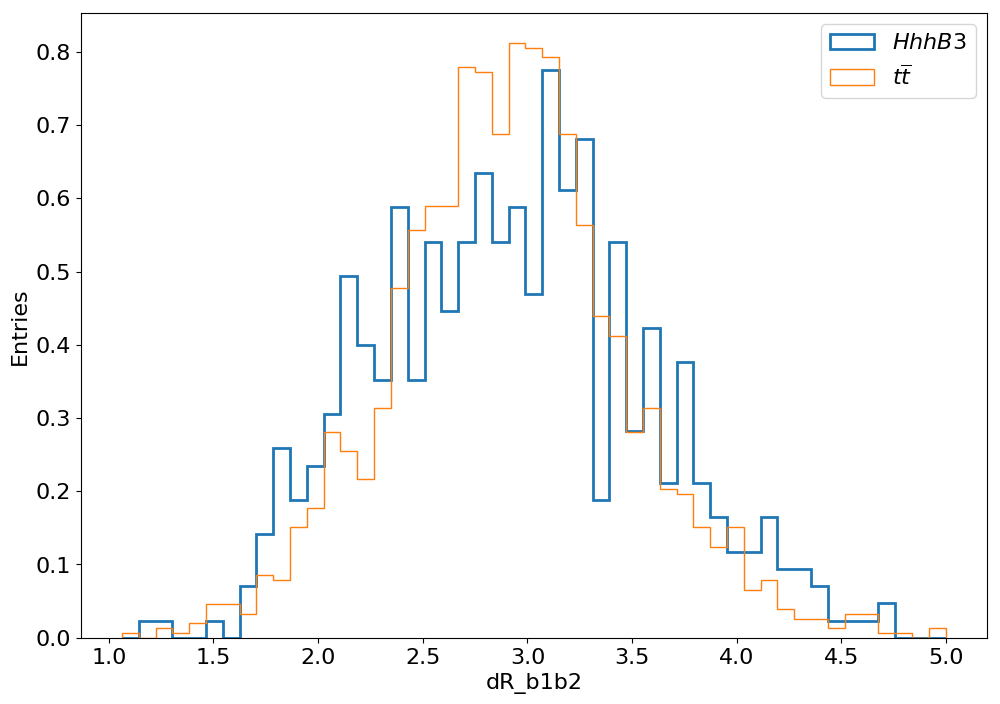

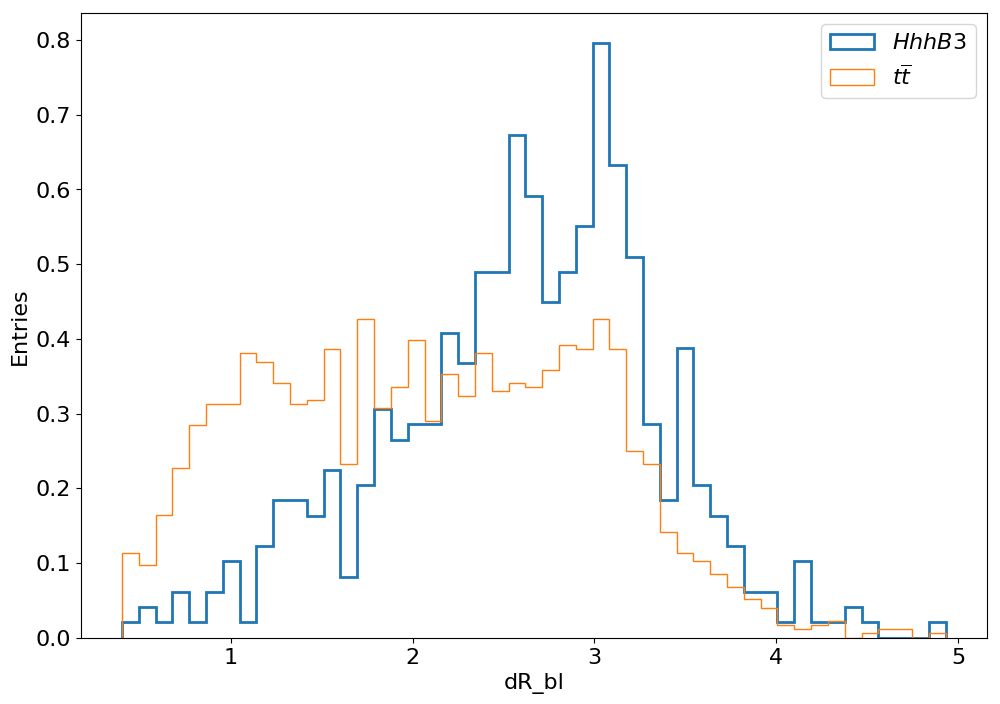

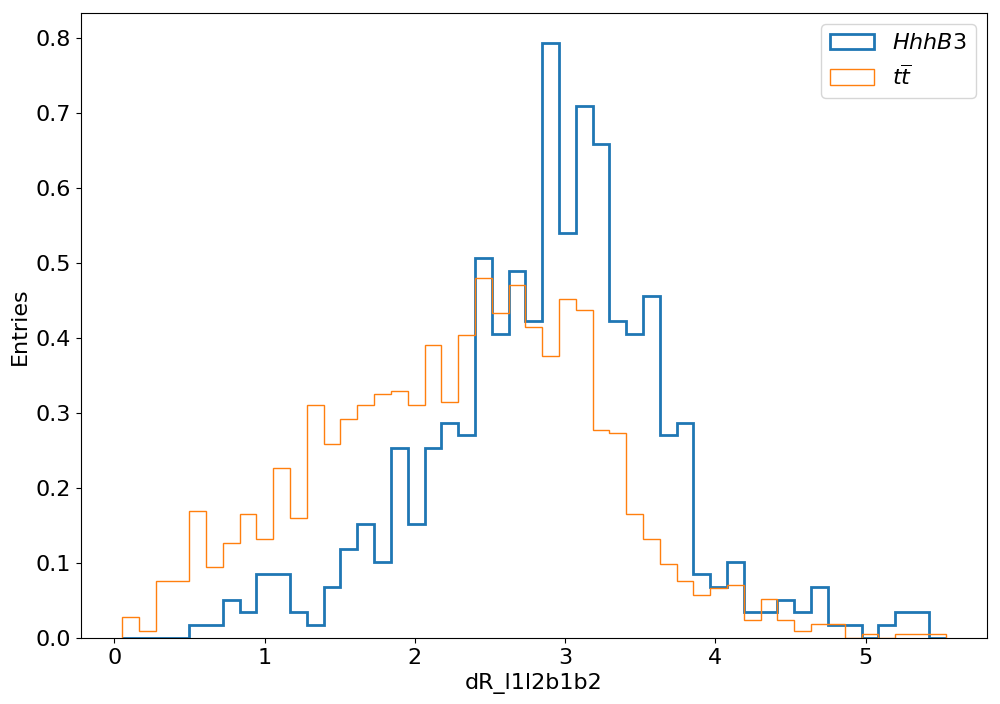

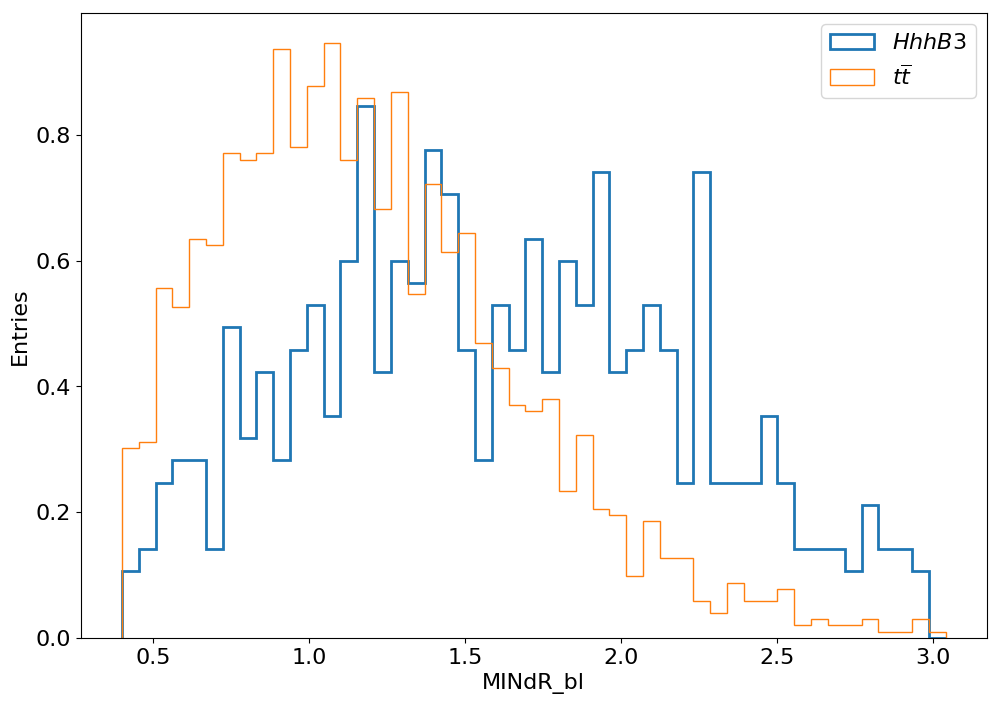

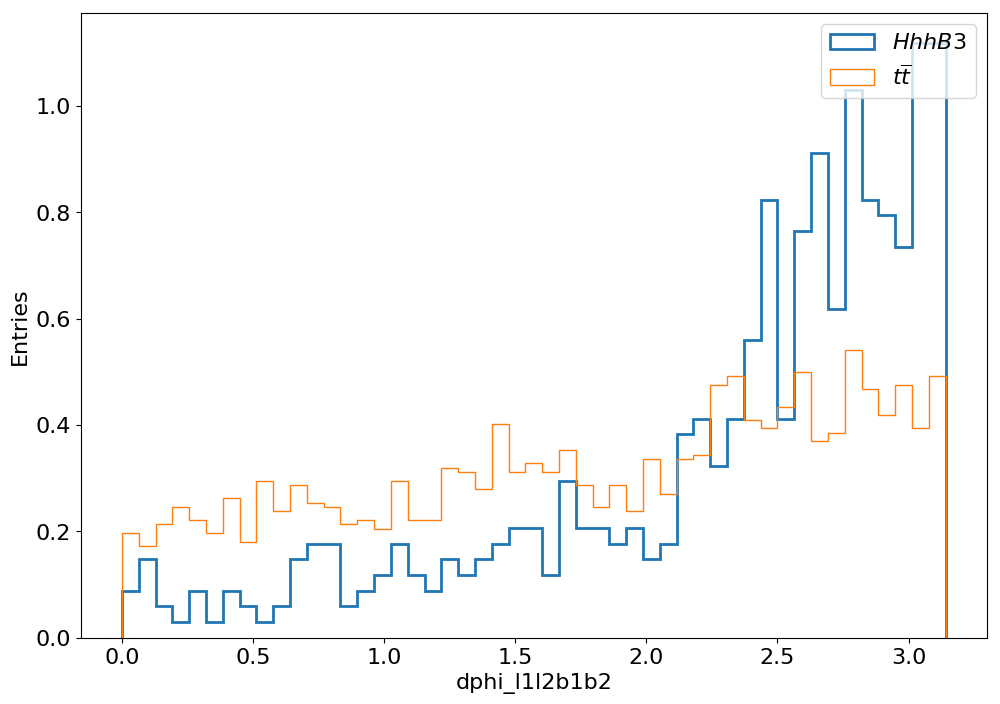

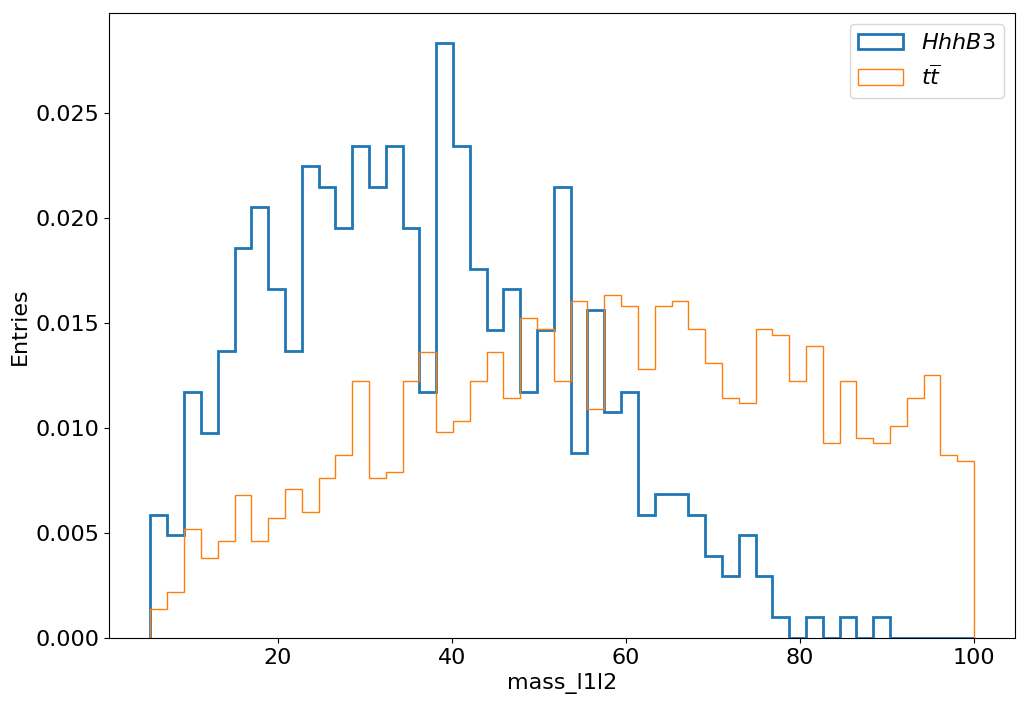

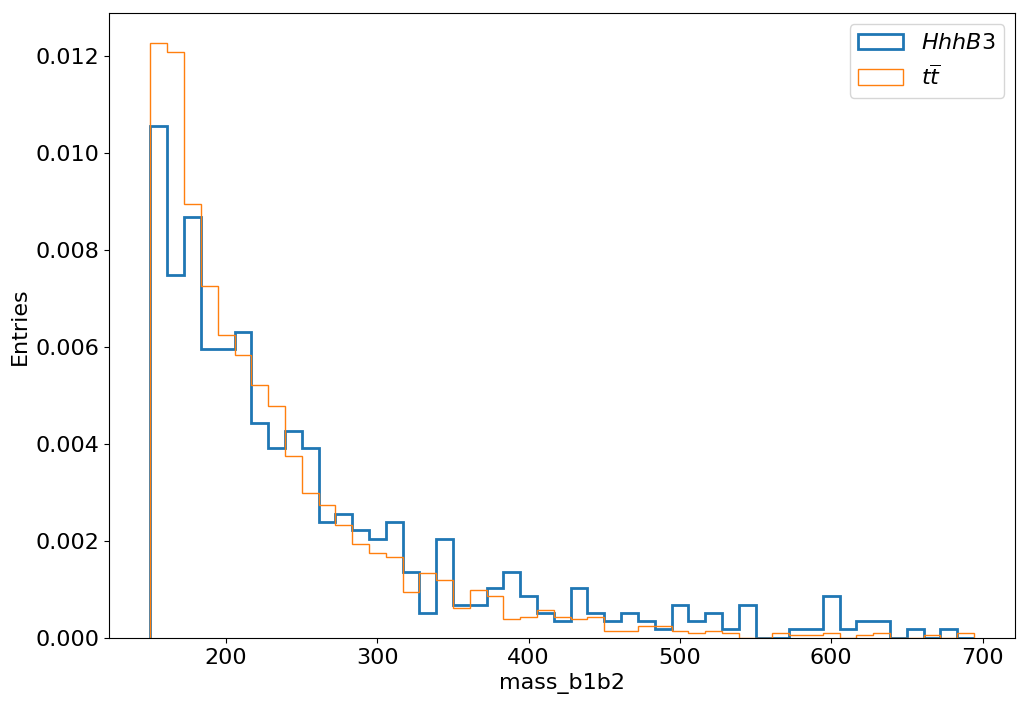

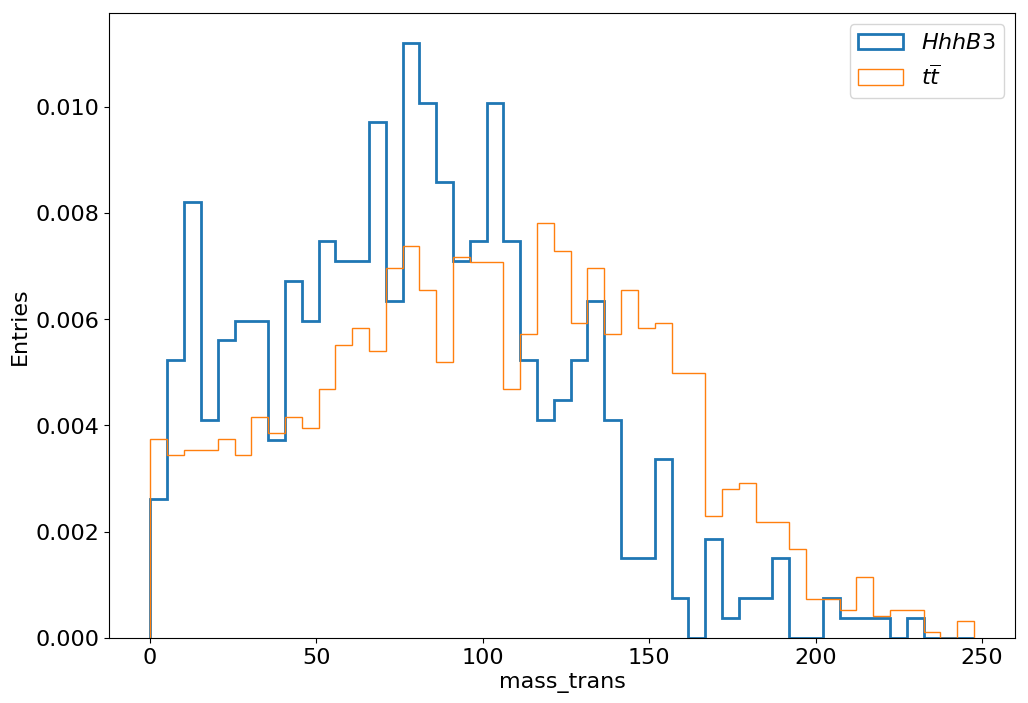

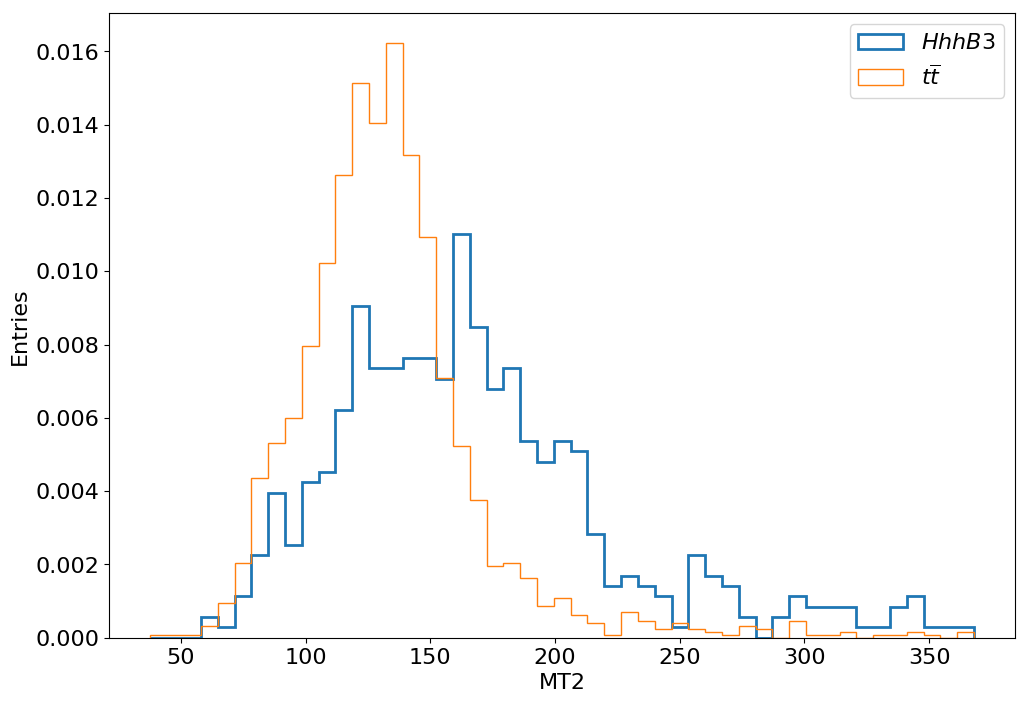

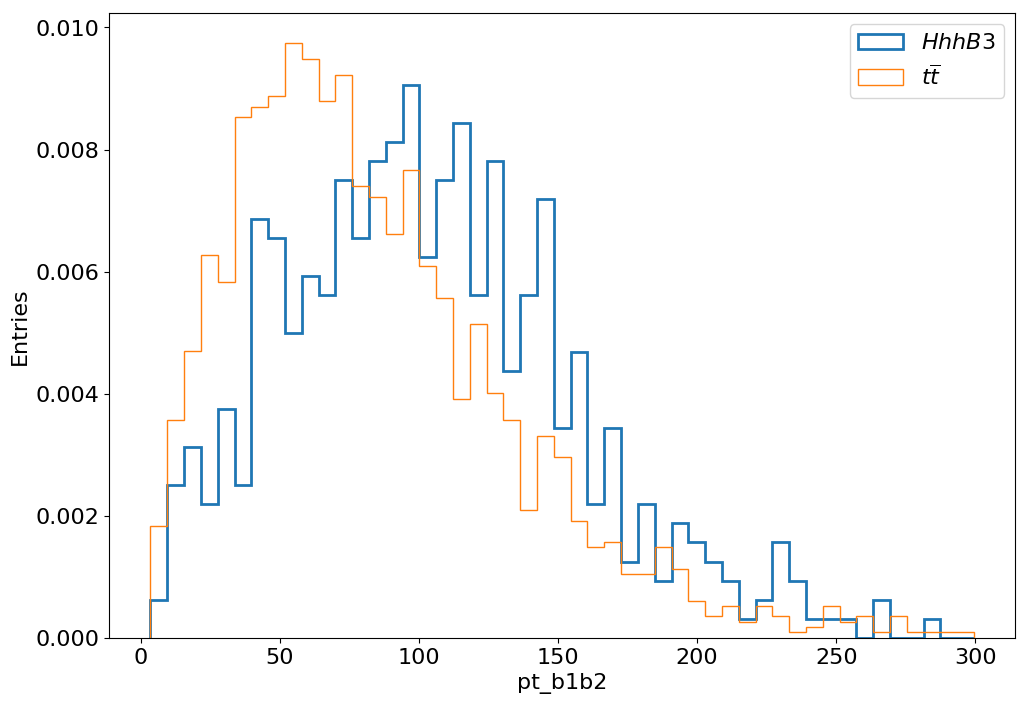

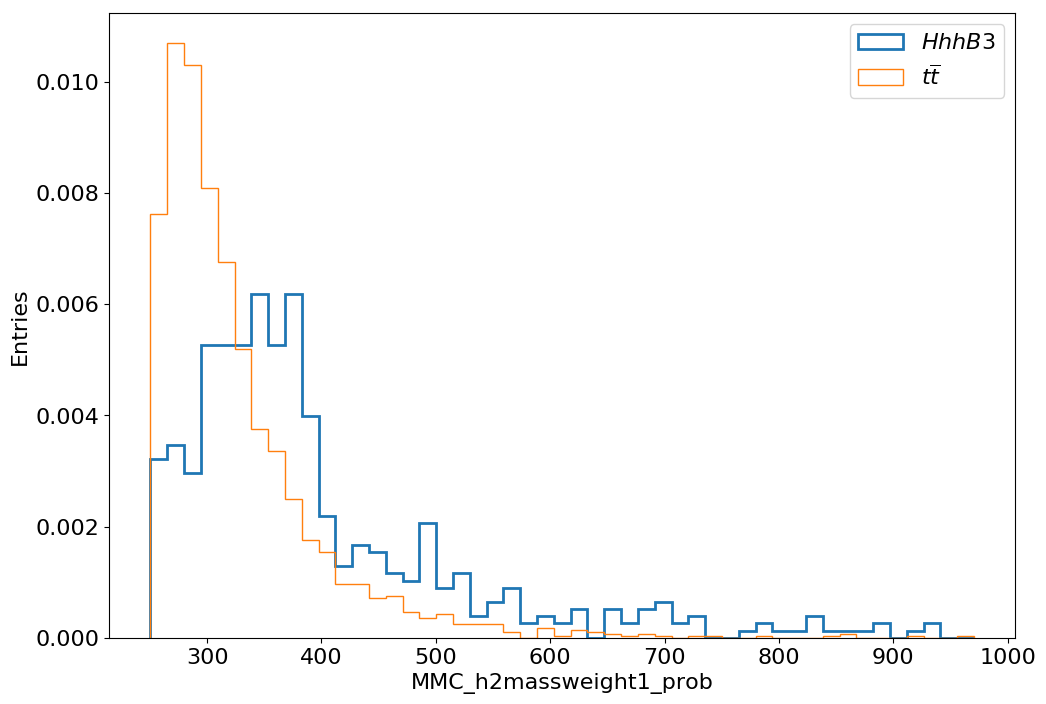

('Saving:', 'Plots_Hhh_tt_MLP//dR_l1l2.png')
('Saving:', 'Plots_Hhh_tt_MLP//dR_b1b2.png')
('Saving:', 'Plots_Hhh_tt_MLP//dR_bl.png')
('Saving:', 'Plots_Hhh_tt_MLP//dR_l1l2b1b2.png')
('Saving:', 'Plots_Hhh_tt_MLP//MINdR_bl.png')
('Saving:', 'Plots_Hhh_tt_MLP//dphi_l1l2b1b2.png')
('Saving:', 'Plots_Hhh_tt_MLP//mass_l1l2.png')
('Saving:', 'Plots_Hhh_tt_MLP//mass_b1b2.png')
('Saving:', 'Plots_Hhh_tt_MLP//mass_trans.png')
('Saving:', 'Plots_Hhh_tt_MLP//MT2.png')
('Saving:', 'Plots_Hhh_tt_MLP//pt_b1b2.png')
('Saving:', 'Plots_Hhh_tt_MLP//MMC_h2massweight1_prob.png')


In [21]:
%matplotlib inline
# Plots of the branches we selected
if (MakePlots) :
  for key in ttbar.keys() :
      if(key!="weight" and key!="reweighting" and key!="fin_weight") :
        matplotlib.rcParams.update({'font.size': 16})
        fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
        bins = np.linspace(my_max(min(ttbar[key]),0.), max(ttbar[key]), 50)
        _ = plt.hist(Hhh3[key],  bins=bins, histtype='step', normed=True, label=r'$Hhh B3$', linewidth=2)
        _ = plt.hist(ttbar[key], bins=bins, histtype='step', normed=True, label=r'$t\overline{t}$')
        plt.xlabel(key)
        plt.ylabel('Entries')
        plt.legend(loc='best')
        print('Saving:',folder + '/' + str(key) + '.png')
        plt.savefig(folder + "/" + str(key) + '.png')

In [13]:
print('Now lets start to talk about DNN!')
# Not lets draw the correlations
c1 = ROOT.TCanvas(); c1.cd(); ROOT.gStyle.SetOptStat(0)
h_Corr_Hhh3  = ROOT.TH2F("h_Corr_Hhh3","", len(my_branches_training), 0, len(my_branches_training), len(my_branches_training), 0, len(my_branches_training))
h_Corr_ttbar = ROOT.TH2F("h_Corr_ttbar","", len(my_branches_training), 0, len(my_branches_training), len(my_branches_training), 0, len(my_branches_training))
for var1 in range(len(my_branches_training)):
  h_Corr_Hhh3.GetXaxis().SetBinLabel(var1+1,my_branches_training[var1])
  h_Corr_ttbar.GetXaxis().SetBinLabel(var1+1,my_branches_training[var1])
  for var2 in range(len(my_branches_training)):
    h_Corr_Hhh3.GetYaxis().SetBinLabel(var2+1,my_branches_training[var2])
    h_Corr_ttbar.GetYaxis().SetBinLabel(var2+1,my_branches_training[var2])
    if(var2>=var1):
      array_Var1_Hhh3_var1 = np.array( Hhh3[my_branches_training[var1]] )
      array_Var1_Hhh3_var2 = np.array( Hhh3[my_branches_training[var2]] )
      array_Var1_ttbar_var1 = np.array( ttbar[my_branches_training[var1]] )
      array_Var1_ttbar_var2 = np.array( ttbar[my_branches_training[var2]] )
      corr = scipy.stats.pearsonr( array_Var1_Hhh3_var1, array_Var1_Hhh3_var2 )[0]
      h_Corr_Hhh3.SetBinContent(var1+1,var2+1,corr)
      corr = scipy.stats.pearsonr( array_Var1_ttbar_var1, array_Var1_ttbar_var2 )[0]
      h_Corr_ttbar.SetBinContent(var1+1,var2+1,corr)
h_Corr_Hhh3.GetZaxis().SetRangeUser(-1.,1.)
h_Corr_ttbar.GetZaxis().SetRangeUser(-1.,1.)
h_Corr_Hhh3.Draw("colzTEXT")
c1.SaveAs(folder + '/Corr_Hhh3.png')
h_Corr_ttbar.Draw("colzTEXT")
c1.SaveAs(folder + '/Corr_ttbar.png')

Now lets start to talk about DNN!


Warning in <TROOT::Append>: Replacing existing TH1: h_Corr_Hhh3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_Corr_ttbar (Potential memory leak).
Info in <TCanvas::Print>: png file Plots_Hhh_tt_MLP//Corr_Hhh3.png has been created
Info in <TCanvas::Print>: png file Plots_Hhh_tt_MLP//Corr_ttbar.png has been created


You need:
1. X : matrix with raw=#Events and column=Variables to discriminate."
2. w : A vector containig the weights of each event"
3. Y : A vector containing for each event if it is signal (0) or TT (1)"

In [14]:
#You only need a Dataframe for the training. So you merge all the one you have
df =  pd.concat((Hhh3[my_branches_training], ttbar[my_branches_training]), ignore_index=True)
# Turn the df the desired ndarray "X" that can be directly used for ML applications.
X = df.as_matrix() # Each row is an object to classify, each column corresponds to a specific variable.
# Take the weights
w =  pd.concat((Hhh3['fin_weight'], ttbar['fin_weight']), ignore_index=True).values
# This is the array with the true values: 0 is signal, 1 if TT.
y = []
for _df, ID in [(Hhh3, 0), (ttbar, 1)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

# Randomly shuffle and automatically split all your objects into train and test subsets
ix = range(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.7) # Train here is 70% of the total statistic
# It is common practice to scale the inputs to Neural Nets such that they have approximately similar ranges.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

You just created X, w, and Y.
 1) X : matrix with raw=#Events and column=Variables to discriminate.
 2) w : A vector containig the weights of each event
 3) X : A vector containing for each event if it is signal (0) or TT (1)


In [15]:
# Multilayer Perceptron (MLP) definition
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu')) # Linear transformation of the input vector. The first number is output_dim.
model.add(Dropout(0.1)) # To avoid overfitting. It masks the outputs of the previous layer such that some of them will randomly become inactive and will not contribute to information propagation.
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Highway(activation='softmax')) # Use adaptive gating units which learn to regulate the flow of information through a network. Improves ability to train very deep feed-forward nets.
model.add(Dropout(0.1))
#model.add(MaxoutDense(10,10)) # A Dense layer that learns its own activation function. Not working in Tensorflow.
model.add(Dense(2, activation='softmax')) # Last layer has to have the same dimensionality as the number of classes we want to predict, here 2.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                130       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
highway_2 (Highway)          (None, 20)                840       
__________

In [16]:
# Now you need to declare what loss function and optimizer to use (and compile your model).
model.compile('adam', 'sparse_categorical_crossentropy')
print('---------------------------Training:---------------------------')
try:
    model.fit(X_train, y_train, validation_split=0.2,
              class_weight={
                0 : compute_class_weight("balanced", [0, 1], y)[0], # Function that return "[1/N_classes * ((float(len(y)) / (y == 0).sum())), 1/N_classes * ((float(len(y)) / (y == 1).sum()))]"
                1 : compute_class_weight("balanced", [0, 1], y)[1]
              },
        initial_epoch=0,
        callbacks = [
            EarlyStopping(verbose=True, patience=6, monitor='val_loss'),
            ModelCheckpoint('models/tutorial-progress.h5', monitor='val_loss', verbose=1, save_best_only=True)
        ]
    )

except KeyboardInterrupt:
    print 'Training ended early.'
### Load the best network (by default you return the last one, you if you save every time you have a better one you are fine loading it later)
##model.load_weights('./models/tutorial-progress.h5')
##print 'Saving weights...'
##model.save_weights('./models/tutorial.h5', overwrite=True)
##json_string = model.to_json()
##open('./models/tutorial.json', 'w').write(json_string)
#print 'Testing...'
##yhat = model.predict(X_test, verbose = True, batch_size = 512) # yhat is the categorization given by the DNN
###Turn them into classes
##yhat_cls = np.argmax(yhat, axis=1) # Returns the indices of the maximum values along axis 1
##bins = np.linspace(-0.5,1.5,3)
##names = ['','Hhh B3','','tt']
##fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
##ax = plt.subplot()
##ax.set_xticklabels(names, rotation=45)
##_ = plt.hist(yhat_cls, bins=bins, histtype='stepfilled', alpha=0.5, label='prediction',log=True)#, weights=w_test)#,log=True)
##_ = plt.hist(y_test, bins=bins, histtype='stepfilled', alpha=0.5, label='truth',log=True)#, weights=w_test)#,log=True)
##plt.legend(loc='upper right')
##print('Saving:',folder + '/Performance.png')
##plt.savefig(folder + '/Performance.png')

##print 'Signal efficiency:',     w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum()
##print 'Background efficiency:', w_test[(y_test != 0) & (yhat_cls == 0)].sum() / w_test[y_test != 0].sum()

AttributeError: 'module' object has no attribute 'global_variables'

---------------------------Training:---------------------------
Train on 1361 samples, validate on 341 samples
Epoch 1/10
